In [1]:
#!pip install SimpleITK 
#!pip install matplotlib
#!pip install scikit-image
#!pip install keras==2.2.5
#!pip install tqdm
#!pip install pandas opencv-python 

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
import os
import gc
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.contrib.tpu.python.tpu import keras_support
import glob
from tqdm.notebook import tqdm
from keras.models import load_model
import pandas
import cv2
import SimpleITK as sitk

Using TensorFlow backend.


In [3]:
K.set_image_data_format("channels_first")
experiment = "LRelu"
dataset_path = '../MICCAI_BraTS17_Data_Training/';
destination_numpy = './Dataset' 
destination_model = './model' 
result_destination = './Result/{}'.format(experiment)

batch_size = 10
start_epoch = 15
continue_training = False
img_size = 240      #original img size is 240*240
smooth = 0.005 
num_of_aug = 2
num_epoch = start_epoch + 35
pul_seq = 'Flair'
sharp = False       # sharpen filter
LR = 1e-4
#verbose = 0 if (num_epoch - start_epoch) > 30 else 1
verbose = 1
num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis+NET, 2 = tumor core, 3= original, 4 = ET, 5 = complete tumor
'''
0: other
1: necrosis + NET
2: edema
4: enhancing tumor
5: full tumor
'''

'\n0: other\n1: necrosis + NET\n2: edema\n4: enhancing tumor\n5: full tumor\n'

In [4]:
def extract_zip(path_zip, destination):
  import zipfile  # For faster extraction
  dataset_path = path_zip  # Replace with your dataset path
  zfile = zipfile.ZipFile(dataset_path)
  zfile.extractall(destination)
  print("Extract Zip file done")

In [5]:
#if os.path.isdir('/content/gdrive/My Drive/Thesis/MICCAI_BraTS17_Data_Training/') == False:
  #extract_zip("/content/gdrive/My Drive/Thesis/MICCAI_BraTS17_Data_Training_IPP.zip", "/content/gdrive/My Drive/Thesis/")
#if os.path.isdir('/content/gdrive/My Drive/Thesis/N4DataValid/') == False:
  #extract_zip("/content/gdrive/My Drive/Thesis/N4DataValid.zip", "/content/gdrive/My Drive/Thesis/")

In [6]:
# function to read all data (training and label) and transform into numpy array

def create_data(src, mask, scanType="flair", augmented=False, label_num = 0, label=False, resize=(155,img_size,img_size)):
    files = glob.glob(src + mask, recursive=True)
    files.sort(reverse=True)
    r.seed(9)
    r.shuffle(files)    # shuffle patients
    imgs = []
    print('Processing---', mask)
    for file in tqdm(files):
        img = io.imread(file, plugin='simpleitk')
        #img = trans.resize(img, resize, mode='constant')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis and NET
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            if label_num == 3:
                img[img == 3] = 1       # remain GT, design for 2015 data
                
                
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
            img = img.astype('float32')
        for slice in range(60,130):     #choose the slice range
            img_t = img[slice,:,:]
            img_t =img_t.reshape((1,)+img_t.shape)
            img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
            if augmented == True:
              img_g = augmentation(img_t,num_of_aug)
            for n in range(img_t.shape[0]):
                if augmented == True:
                  imgs.append(img_g[n,:,:,:])
                else:
                  imgs.append(img_t[n,:,:,:])
    name = 'y_'+ str(img_size) if label else 'x_'+ str(img_size)
    if label == False:
      name = name + '_' + scanType
    else:
      name = name + '_' + str(label_num)
    np.save('{}/{}.npy'.format(destination_numpy, name), np.array(imgs).astype('float32'))  # save at home
    print('Saved', len(files), 'to', name)
    del imgs
    gc.collect()
    #return np.array(imgs)

In [7]:
#function to read one subject data
def create_data_onesubject_val(src, mask, count, label_num = 0, label=False):
    files = glob.glob(src + mask, recursive=True)
    #r.seed(9)
    #r.shuffle(files)    # shuffle patients
    k = len(files) - count -1
    imgs = []
    file = files[k]
    print('Processing---', mask,'--',file)
    
    img = io.imread(file, plugin='simpleitk')
    #img = trans.resize(img, resize, mode='constant')
    if label:
        if label_num == 5:
            img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
        if label_num == 1:
            img[img != 1] = 0       #only left necrosis
        if label_num == 2:
            img[img == 2] = 0       #turn edema to 0
            img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
        if label_num == 4:
            img[img != 4] = 0       #only left ET
            img[img == 4] = 1
        img = img.astype('float32')
    else:
        img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
        img = img.astype('float32')
    for slice in range(155):     #choose the slice range
        img_t = img[slice,:,:]
        img_t =img_t.reshape((1,)+img_t.shape)
        img_t =img_t.reshape((1,)+img_t.shape)   #become rank 4
        #img_g = augmentation(img_t,num_of_aug)
        for n in range(img_t.shape[0]):
            imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [8]:
def augmentation(scans,n):          #input img must be rank 4 
    datagen = ImageDataGenerator(
        featurewise_center=False,   
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=25,   
        width_shift_range=0.1,  
        height_shift_range=0.1,   
        horizontal_flip=True,   
        vertical_flip=True,  
        zoom_range=0.1)
    i=0
    scans_g=scans.copy()
    for batch in datagen.flow(scans, batch_size=1, seed=1000): 
        scans_g=np.vstack([scans_g,batch])
        i += 1
        if i == n:
            break
    '''    remember arg + labels  
    i=0
    labels_g=labels.copy()
    for batch in datagen.flow(labels, batch_size=1, seed=1000): 
        labels_g=np.vstack([labels_g,batch])
        i += 1
        if i > n:
            break    
    return ((scans_g,labels_g))'''
    return scans_g

In [9]:
def create_graph(history, epoch, path):
  #create list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['dice_coef'])
  plt.plot(history.history['val_dice_coef'])
  plt.title('model dice_coef')
  plt.ylabel('dice_coef')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.savefig('{}/dice_coef_{}.png'.format(path, epoch), dpi=300)
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('{}/val_loss_{}.png'.format(path, epoch), dpi=300)
  plt.show()

  plt.close()

In [10]:

# our U-net for full tumor segmentation
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
def leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.2)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model(input=1):
    inputs = Input((input, img_size, img_size))
    conv1 = Conv2D(64, (3, 3), activation=leaky_relu, padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation=leaky_relu, padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation=leaky_relu, padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation=leaky_relu, padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation=leaky_relu, padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation=leaky_relu, padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation=leaky_relu, padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation=leaky_relu, padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation=leaky_relu, padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation=leaky_relu, padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation=leaky_relu, padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation=leaky_relu, padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation=leaky_relu, padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation=leaky_relu, padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation=leaky_relu, padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation=leaky_relu, padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation=leaky_relu, padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation=leaky_relu, padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=LR), loss=dice_coef_loss, metrics=[dice_coef])

  
    return model

In [11]:

augmented = True
#flair
if os.path.isfile('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "flair")) == False:
  create_data(dataset_path, '**/*_flair.nii.gz', scanType="flair", label=False, augmented=augmented, resize=(155,img_size,img_size))

#t2
if os.path.isfile('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "t2")) == False:
  create_data(dataset_path, '**/*_t2.nii.gz', scanType="t2", label=False, augmented=augmented, resize=(155,img_size,img_size))


#segmentation Full Tumor
if os.path.isfile('{}/y_{}_{}.npy'.format(destination_numpy, img_size, 5)) == False:
  create_data(dataset_path, '**/*_seg.nii.gz', label=True, label_num = 5, augmented=augmented, resize=(155,img_size,img_size))

#Load other module BRATS (t1ce and ET, Core GT)
#t1
if os.path.isfile('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "t1")) == False:
  create_data(dataset_path, '**/*_t1.nii.gz', scanType="t1", label=False, augmented=augmented, resize=(155,img_size,img_size))

#t1ce
if os.path.isfile('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "t1ce")) == False:
  create_data(dataset_path, '**/*_t1ce.nii.gz', scanType="t1ce", label=False, augmented=augmented, resize=(155,img_size,img_size))

#segmentation Core Tumor
if os.path.isfile('{}/y_{}_{}.npy'.format(destination_numpy,img_size, 2)) == False:
  create_data(dataset_path, '**/*_seg.nii.gz', label=True, label_num = 2, augmented=augmented, resize=(155,img_size,img_size))

#segmentation ET Tumor
if os.path.isfile('{}/y_{}_{}.npy'.format(destination_numpy, img_size, 4)) == False:
  create_data(dataset_path, '**/*_seg.nii.gz', label=True, label_num = 4, augmented=augmented, resize=(155,img_size,img_size))



In [12]:
Flair = np.load('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "flair"))
T1 = np.load('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "t1"))
T2 = np.load('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "t2"))
T1c = np.load('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "t1ce"))

x_train = np.hstack((Flair, T1, T2, T1c))
del Flair
del T1
del T2
del T1c
gc.collect()



12

In [13]:
y_train = np.load('{}/y_{}_{}.npy'.format(destination_numpy, img_size, 5))
checkpoint_path = '{}/{}/weight_full_best.h5'.format(destination_model, experiment)
isBuildNewModel = True if os.path.isfile(checkpoint_path) == False else False
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')

model = unet_model(4)
if isBuildNewModel == True:
  history = model.fit(x_train, y_train, batch_size=batch_size, callbacks=[model_checkpoint, early_stop], validation_split=0.2, epochs= num_epoch, verbose=verbose, shuffle=True)
  create_graph(history, start_epoch, '{}/full'.format(result_destination))
  pandas.DataFrame(history.history).to_csv("{}/history_full_{}.csv".format(result_destination, start_epoch))
  #model.save(model_checkpoint)
else:
  model = load_model(checkpoint_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef, 'leaky_relu': leaky_relu})
  if continue_training == False :
    scores = model.evaluate(x_train, y_train, verbose = 0)
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  else:
    history = model.fit(x_train, y_train, batch_size=batch_size, callbacks=[model_checkpoint, early_stop], validation_split=0.2, epochs= num_epoch, initial_epoch=start_epoch, verbose=verbose, shuffle=True)
    create_graph(history, start_epoch, '{}/full'.format(result_destination))
    pandas.DataFrame(history.history).to_csv("{}/history_full_{}.csv".format(result_destination, start_epoch))
















loss: 0.13%
dice_coef: 86.71%


In [14]:
del y_train
#del x_train
gc.collect()

#T1c = np.load('{}/x_{}_{}.npy'.format(destination_numpy, img_size, "t1ce"))
#x_train = np.hstack(( T2, T1c))
#del T2
#del T1c
#gc.collect()

170

In [15]:
y_train = np.load('{}/y_{}_{}.npy'.format(destination_numpy, img_size, 4))
checkpoint_path = '{}/{}/weight_et_best.h5'.format(destination_model, experiment)
isBuildNewModel = True if os.path.isfile(checkpoint_path) == False else False
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')

model_ET = unet_model(4)
if isBuildNewModel == True:
  history = model_ET.fit(x_train, y_train, batch_size=batch_size, callbacks=[model_checkpoint, early_stop], validation_split=0.2, epochs= num_epoch, verbose=verbose, shuffle=True)
  create_graph(history, start_epoch, '{}/et'.format(result_destination))
  pandas.DataFrame(history.history).to_csv("{}/history_et_{}.csv".format(result_destination, start_epoch))
else:
  model_ET = load_model(checkpoint_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef, 'leaky_relu': leaky_relu})
  if continue_training == False :
    scores = model_ET.evaluate(x_train, y_train, verbose = 0)
    print("%s: %.2f%%" % (model_ET.metrics_names[0], scores[0]))
    print("%s: %.2f%%" % (model_ET.metrics_names[1], scores[1]*100))
  else:
    history = model_ET.fit(x_train, y_train, batch_size=batch_size, callbacks=[model_checkpoint, early_stop], validation_split=0.2, epochs= num_epoch, initial_epoch=start_epoch, verbose=verbose, shuffle=True)
    create_graph(history, start_epoch, '{}/et'.format(result_destination))
    pandas.DataFrame(history.history).to_csv("{}/history_et_{}.csv".format(result_destination, start_epoch))

loss: 0.24%
dice_coef: 76.10%


In [16]:
del y_train
gc.collect()

161

In [17]:
y_train = np.load('{}/y_{}_{}.npy'.format(destination_numpy, img_size, 2))
checkpoint_path = '{}/{}/weight_core_best.h5'.format(destination_model, experiment)
isBuildNewModel = True if os.path.isfile(checkpoint_path) == False else False
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')

model_core = unet_model(4)
if isBuildNewModel == True:
  history = model_core.fit(x_train, y_train, batch_size=batch_size, callbacks=[model_checkpoint, early_stop], validation_split=0.2, epochs= num_epoch, verbose=verbose, shuffle=True)
  create_graph(history, start_epoch, '{}/core'.format(result_destination))
  pandas.DataFrame(history.history).to_csv("{}/history_core_{}.csv".format(result_destination, start_epoch))
else:
  model_core = load_model(checkpoint_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef, 'leaky_relu': leaky_relu})
  if continue_training == False :
    scores = model_core.evaluate(x_train, y_train, verbose = 0)
    print("%s: %.2f%%" % (model_core.metrics_names[0], scores[0]))
    print("%s: %.2f%%" % (model_core.metrics_names[1], scores[1]*100))
  else:
    history = model_core.fit(x_train, y_train, batch_size=batch_size, callbacks=[model_checkpoint, early_stop], validation_split=0.2, epochs= num_epoch, initial_epoch=start_epoch, verbose=verbose, shuffle=True)
    create_graph(history, start_epoch, '{}/core'.format(result_destination))
    pandas.DataFrame(history.history).to_csv("{}/history_core_{}.csv".format(result_destination, start_epoch))

loss: 0.32%
dice_coef: 68.22%


In [18]:
del x_train
del y_train
gc.collect()

170

Processing--- **/*flair.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_flair.nii.gz
Processing--- **/*t1ce.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_t1ce.nii.gz
Processing--- **/*t1.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_t1.nii.gz
Processing--- **/*t2.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_t2.nii.gz
Processing--- **/*seg.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_seg.nii.gz
Processing--- **/*seg.nii.gz -- ../MICCAI_BraTS17_Data_Training//HGG/Brats17_TCIA_430_1/Brats17_TCIA_430_1_seg.nii.gz


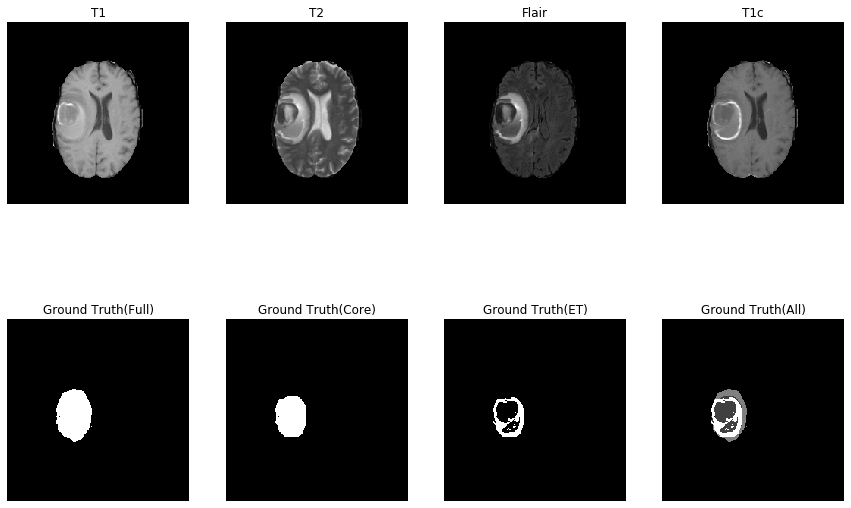

In [19]:
#read one subject to show slices
#path_hgg = '{}/HGG/'.format(dataset_path)
path_hgg = "{}/{}/{}/".format(dataset_path, "HGG","Brats17_TCIA_430_1")
count = 1 #number of files on HGG
pul_seq = 'flair'
Flair_Predict = create_data_onesubject_val(path_hgg, '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't1ce'
T1c_Predict = create_data_onesubject_val(path_hgg, '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't1'
T1_Predict = create_data_onesubject_val(path_hgg, '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't2'
T2_Predict = create_data_onesubject_val(path_hgg, '**/*{}.nii.gz'.format(pul_seq), count, label=False)

# Full Segmentation Tumor
Label_full_Predict = create_data_onesubject_val(path_hgg, '**/*seg.nii.gz', count, label_num = 5, label=True)
#Core Segmentation Tumor
Label_core_Predict = create_data_onesubject_val(path_hgg, '**/*seg.nii.gz', count, label_num = 2, label=True)
#ET Segmentation Tumor
Label_ET_Predict = create_data_onesubject_val(path_hgg, '**/*seg.nii.gz', count, label_num = 4, label=True)
#Join All Segmentation
Label_all_Predict = create_data_onesubject_val(path_hgg, '**/*seg.nii.gz', count, label_num = 3, label=True)

fig = plt.figure(figsize=(15,10))

plt.subplot(241)
plt.title('T1')
plt.axis('off')
plt.imshow(T1_Predict[90, 0, :, :],cmap='gray')

plt.subplot(242)
plt.title('T2')
plt.axis('off')
plt.imshow(T2_Predict[90, 0, :, :],cmap='gray')
    
plt.subplot(243)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair_Predict[90, 0, :, :],cmap='gray')

plt.subplot(244)
plt.title('T1c')
plt.axis('off')
plt.imshow(T1c_Predict[90, 0, :, :],cmap='gray')

plt.subplot(245)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(Label_full_Predict[90, 0, :, :],cmap='gray')

plt.subplot(246)
plt.title('Ground Truth(Core)')
plt.axis('off')
plt.imshow(Label_core_Predict[90, 0, :, :],cmap='gray')

plt.subplot(247)
plt.title('Ground Truth(ET)')
plt.axis('off')
plt.imshow(Label_ET_Predict[90, 0, :, :],cmap='gray')

plt.subplot(248)
plt.title('Ground Truth(All)')
plt.axis('off')
plt.imshow(Label_all_Predict[90, 0, :, :],cmap='gray')

plt.show()
fig.savefig('{}/tumor.png'.format(result_destination), dpi=300)
plt.close(fig)

In [20]:
#x1 = np.zeros((1,4,240,240),np.float32)
#x1[:,:1,:,:] = Flair_Predict[89:90,:,:,:]  #choosing 90th slice as example
#x1[:,1:,:,:] = T2_Predict[89:90,:,:,:] 
x1 = np.hstack((Flair_Predict[89:90,:,:,:], T1_Predict[89:90,:,:,:], T2_Predict[89:90,:,:,:], T1c_Predict[89:90,:,:,:]))
pred_full = model.predict(x1)

#x2 = np.zeros((1,4,240,240),np.float32)
#x2[:,:1,:,:] = T2_Predict[89:90,:,:,:]  #choosing 90th slice as example
#x2[:,1:,:,:] = T1c_Predict[89:90,:,:,:] 
#pred_full = model.predict(x1)

pred_core = model_core.predict(x1)
pred_ET = model_ET.predict(x1)

In [21]:
def paint_color_algo(pred_full, pred_core , pred_ET ):   #input image is [n,1, y, x]
    # first put the pred_full on T1c
    pred_full[pred_full > 0.2] = 2      #240x240
    pred_full[pred_full != 2] = 0
    pred_core[pred_core > 0.2] = 1      #64x64
    pred_core[pred_core != 1] = 0
    pred_ET[pred_ET > 0.2] = 4          #64x64
    pred_ET[pred_ET != 4] = 0

    total = np.zeros((1,240,240),np.float32)  
    total[:,:,:] = pred_full[:,:,:]
    for i in range(pred_core.shape[0]):
        for j in range(240):
            for k in range(240):
                if pred_core[i,j,k] != 0 and pred_full[i,j,k] !=0:
                    total[i,j,k] = pred_core[i,j,k]
                if pred_ET[i,j,k] != 0 and pred_full[i,j,k] !=0:
                    total[i,j,k] = pred_ET[i,j,k]
                
    
    
    return total

In [22]:
tmp = paint_color_algo(pred_full[0,:,:,:], pred_core[0,:,:,:], pred_ET[0,:,:,:])

core = np.zeros((1,240,240),np.float32)
ET = np.zeros((1,240,240),np.float32)
core[:,:,:] = tmp[:,:,:]
ET[:,:,:] = tmp[:,:,:]
core[core == 4] = 1
core[core != 1] = 0
ET[ET != 4] = 0

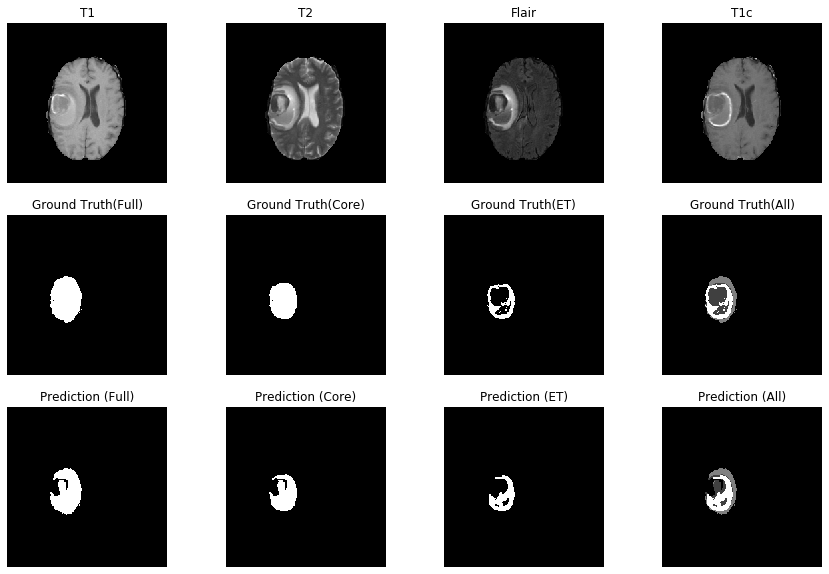

In [23]:
fig = plt.figure(figsize=(15,10))

plt.subplot(341)
plt.title('T1')
plt.axis('off')
plt.imshow(T1_Predict[90, 0, :, :],cmap='gray')

plt.subplot(342)
plt.title('T2')
plt.axis('off')
plt.imshow(T2_Predict[90, 0, :, :],cmap='gray')
    
plt.subplot(343)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair_Predict[90, 0, :, :],cmap='gray')

plt.subplot(344)
plt.title('T1c')
plt.axis('off')
plt.imshow(T1c_Predict[90, 0, :, :],cmap='gray')

plt.subplot(345)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(Label_full_Predict[90, 0, :, :],cmap='gray')

plt.subplot(346)
plt.title('Ground Truth(Core)')
plt.axis('off')
plt.imshow(Label_core_Predict[90, 0, :, :],cmap='gray')

plt.subplot(347)
plt.title('Ground Truth(ET)')
plt.axis('off')
plt.imshow(Label_ET_Predict[90, 0, :, :],cmap='gray')

plt.subplot(348)
plt.title('Ground Truth(All)')
plt.axis('off')
plt.imshow(Label_all_Predict[90, 0, :, :],cmap='gray')

plt.subplot(349)
plt.title('Prediction (Full)')
plt.axis('off')
plt.imshow(pred_full[0, 0, :, :],cmap='gray')

plt.subplot(3,4,10)
plt.title('Prediction (Core)')
plt.axis('off')
plt.imshow(core[0, :, :],cmap='gray')

plt.subplot(3,4,11)
plt.title('Prediction (ET)')
plt.axis('off')
plt.imshow(ET[0, :, :],cmap='gray')

plt.subplot(3,4,12)
plt.title('Prediction (All)')
plt.axis('off')
plt.imshow(tmp[0, :, :],cmap='gray')

plt.show()

fig.savefig('{}/all_segmentation_{}.png'.format(result_destination, start_epoch))
plt.close(fig)